# Environment import

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
%matplotlib inline

# Prepare Dataset

In [2]:
class2text = {
    0: 'Car',
    1: 'Motorcycle',
    2: 'Bicycle'
}
num_class = 3

In [3]:
from tensorflow.keras.preprocessing import image

def load_dataset(data_df):
    '''Function to load dataset.'''
    x = []
    y = []
    for i, r in data_df.iterrows():
        f = os.path.join('./dataset', r['filename'])   # filename
        c = r['label']                              # class
        # Load and resize the image
        img = image.load_img(f, target_size=(224, 224))

        # Convert the Image object into a numpy array
        img = image.img_to_array(img)
        
        x.append(img)
        y.append(c)
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

## Import Dataset From CSV

In [4]:
df = pd.read_csv('./dataset/image.csv', index_col=0)
df

,filename,label
0,01.jpg,0
1,02.jpeg,0
2,03.jpeg,0
3,04.jpeg,0
4,05.jpeg,0
...,...,...
64,65.jpg,1
65,66.jpg,1
66,67.jpg,2
67,68.jpg,2


## Load Image to X and Y

In [5]:
X,Y = load_dataset(df)

# Preprocessing

 ## Seperate train and test

In [6]:
from sklearn.model_selection import train_test_split
from keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical


raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(X, Y, shuffle=True , test_size=0.3, random_state=42)

# Preprocess the input array
X_train = preprocess_input(raw_X_train)
X_test = preprocess_input(raw_X_test)

# Convert class data to one-hot format
y_train = to_categorical(raw_y_train, num_class)
y_test = to_categorical(raw_y_test, num_class)

# Convert the preprocessing images into `float32`
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Convert the one-hot vector into `int`
y_train = y_train.astype(np.int_)
y_test = y_test.astype(np.int_)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (48, 224, 224, 3), (48, 3)
Test set: (21, 224, 224, 3), (21, 3)


# Transfer Learning

In [7]:
import tensorflow.keras
from keras.applications.mobilenet_v2 import MobileNetV2

# Create the base pre-trained model
# Note: include_top=False --> do not include the top layers
#       This allows us to replace the top with new layers for transfer learning
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    weights='imagenet',  #ถ้าเอา comment นี้ออก คือการใช้ weight ของ model ที่ให้มา
    #weights=None,      #ถ้าเอา comment นี้ออก คือการเทรนเอง ไม่ได้ใช้ weight ของ model ที่ให้มา
    include_top=False)

In [8]:
from keras.models import Sequential
from keras.layers import *

model = Sequential()

# Start with the base_model
model.add(base_model)

# Add a global spatial average pooling layer
model.add(GlobalAveragePooling2D())

# A fully-connected layer
model.add(Dense(1024, activation='relu'))

# A softmax layer -- note that we have 5 classes
model.add(Dense(num_class, activation='softmax'))

In [9]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 mobilenetv2_1.00_224
1 global_average_pooling2d
2 dense
3 dense_1


## Train only top layers

In [10]:
# Freeze all layers in the MobileNetV2, except the ones we have just added.
for layer in base_model.layers:
    layer.trainable = False  #ปรับ Gradient เฉพาะ Layer ใหม่ อันอื่นคงเดิม

In [11]:
epochs = 10
batch_size = 5
learning_rate = 0.001

# SGD optimizer (you can use others)
optimizer = tensorflow.keras.optimizers.SGD(learning_rate)

# Cross-entropy loss
loss = tensorflow.keras.losses.categorical_crossentropy

# Compile the model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy'])

In [12]:
hist = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/10


2025-02-19 15:38:23.099561: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 1s 28ms/step - loss: 1.0119 - accuracy: 0.5833
Epoch 2/10
10/10 [==============================] - 0s 29ms/step - loss: 0.8314 - accuracy: 0.6875
Epoch 3/10
10/10 [==============================] - 0s 30ms/step - loss: 0.6991 - accuracy: 0.8125
Epoch 4/10
10/10 [==============================] - 0s 30ms/step - loss: 0.5970 - accuracy: 0.9583
Epoch 5/10
10/10 [==============================] - 0s 30ms/step - loss: 0.5115 - accuracy: 0.9583
Epoch 6/10
10/10 [==============================] - 0s 30ms/step - loss: 0.4462 - accuracy: 0.9583
Epoch 7/10
10/10 [==============================] - 0s 31ms/step - loss: 0.3971 - accuracy: 0.9792
Epoch 8/10
10/10 [==============================] - 0s 30ms/step - loss: 0.3541 - accuracy: 0.9792
Epoch 9/10
10/10 [==============================] - 0s 35ms/step - loss: 0.3193 - accuracy: 1.0000
Epoch 10/10
10/10 [==============================] - 0s 30ms/step - loss: 0.2904 - accuracy: 1.0000


In [13]:
score = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4417516589164734
Test accuracy: 0.8571428656578064


## Fine-tuning model

In [14]:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu
48 b

In [15]:
n_freezes = 0

for layer in base_model.layers[:n_freezes]:
   layer.trainable = False
for layer in base_model.layers[n_freezes:]:
   layer.trainable = True

In [16]:
epochs = 10
batch_size = 5
learning_rate = 0.001

# We use SGD with a lower learning rate, compared to the training above
optimizer = tensorflow.keras.optimizers.SGD(learning_rate)

# Cross-entropy loss
loss = tensorflow.keras.losses.categorical_crossentropy

# Compile the model
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy'])

In [17]:
hist = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/10
10/10 [==============================] - 2s 124ms/step - loss: 0.7890 - accuracy: 0.6875
Epoch 2/10
10/10 [==============================] - 1s 126ms/step - loss: 0.6610 - accuracy: 0.8333
Epoch 3/10
10/10 [==============================] - 1s 129ms/step - loss: 0.6454 - accuracy: 0.8333
Epoch 4/10
10/10 [==============================] - 1s 121ms/step - loss: 0.6219 - accuracy: 0.7917
Epoch 5/10
10/10 [==============================] - 1s 125ms/step - loss: 0.6062 - accuracy: 0.8542
Epoch 6/10
10/10 [==============================] - 1s 128ms/step - loss: 0.5168 - accuracy: 0.9167
Epoch 7/10
10/10 [==============================] - 1s 132ms/step - loss: 0.4384 - accuracy: 0.9167
Epoch 8/10
10/10 [==============================] - 1s 125ms/step - loss: 0.3614 - accuracy: 0.9792
Epoch 9/10
10/10 [==============================] - 1s 124ms/step - loss: 0.3546 - accuracy: 0.9375
Epoch 10/10
10/10 [==============================] - 1s 125ms/step - loss: 0.4357 - accuracy: 0.8958

In [18]:
score = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.29408732056617737
Test accuracy: 0.9047619104385376


# Test new image (Test_image.jpg)

In [19]:
files = 'Test_image.JPG'

[image Test_image.JPG]


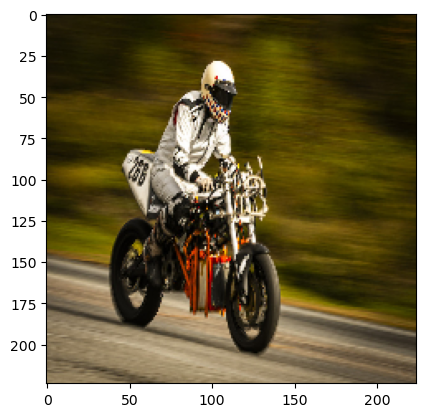

Image shape: (1, 224, 224, 3)


In [20]:
images = []
img = image.load_img(files, target_size=(224, 224))

# Convert the Image object into a numpy array
img = image.img_to_array(img)

# Add to a list of images
images.append(img)

# Visualize the resize image
print(f'[image {files}]')
plt.imshow(image.img_to_array(img).astype('uint8'))
plt.show()
plt.close("all")
images = np.asarray(images)
x = preprocess_input(images)

print(f"Image shape: {x.shape}")

In [21]:
probs = model.predict(x)

# Display the results
for i in range(1):
    print(f'[image {files[i]}]')
    for c in range(num_class):
        print(f'{class2text[c]} ({probs[i][c]*100:.2f}%)')
    print('')

1/1 [==============================] - 0s 275ms/step
[image T]
Car (1.55%)
Motorcycle (92.46%)
Bicycle (5.99%)



# Using K-Fold

Since the dataset is very small, I think it's okay to test out the K-Fold

Learning this from : https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md

In [22]:
from sklearn.model_selection import KFold

k = 5
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Put train and test together
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)


In [23]:
for train, test in kf.split(inputs,targets):

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(num_class, activation='softmax'))
    optimizer = tensorflow.keras.optimizers.SGD(learning_rate)
    loss = tensorflow.keras.losses.categorical_crossentropy
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    hist = model.fit(inputs[train], targets[train],
                batch_size=batch_size,
                epochs=epochs,
                verbose=1)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no = fold_no + 1

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
11/11 [==============================] - 2s 126ms/step - loss: 1.0643 - accuracy: 0.4364
Epoch 2/10
11/11 [==============================] - 1s 123ms/step - loss: 0.8788 - accuracy: 0.6364
Epoch 3/10
11/11 [==============================] - 1s 132ms/step - loss: 0.7426 - accuracy: 0.7091
Epoch 4/10
11/11 [==============================] - 1s 133ms/step - loss: 0.6781 - accuracy: 0.7818
Epoch 5/10
11/11 [==============================] - 2s 145ms/step - loss: 0.5526 - accuracy: 0.8909
Epoch 6/10
11/11 [==============================] - 2s 140ms/step - loss: 0.5359 - accuracy: 0.8545
Epoch 7/10
11/11 [==============================] - 1s 126ms/step - loss: 0.4208 - accuracy: 0.9455
Epoch 8/10
11/11 [==============================] - 1s 129ms/step - loss: 0.3619 - accuracy: 0.9455
Epoch 9/10
11/11 [==============================] - 1s 130ms/step - loss: 0.3210 - accuracy: 0.9455
Epo

Score for fold 1: loss of 0.49776148796081543; accuracy of 100.0%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
11/11 [==============================] - 2s 124ms/step - loss: 1.0800 - accuracy: 0.3818
Epoch 2/10
11/11 [==============================] - 1s 130ms/step - loss: 0.8649 - accuracy: 0.6364
Epoch 3/10
11/11 [==============================] - 1s 131ms/step - loss: 0.6790 - accuracy: 0.8727
Epoch 4/10
11/11 [==============================] - 1s 131ms/step - loss: 0.6928 - accuracy: 0.8182
Epoch 5/10
11/11 [==============================] - 1s 130ms/step - loss: 0.5556 - accuracy: 0.8909
Epoch 6/10
11/11 [==============================] - 1s 131ms/step - loss: 0.5765 - accuracy: 0.8545
Epoch 7/10
11/11 [==============================] - 1s 131ms/step - loss: 0.4501 - accuracy: 0.9273
Epoch 8/10
11/11 [==============================] - 1s 130ms/step - loss: 0.4360 - accuracy: 0.9273
Epoch 9/10
11/11 [===================

Score for fold 2: loss of 0.34349197149276733; accuracy of 92.85714030265808%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/10
11/11 [==============================] - 3s 170ms/step - loss: 1.2082 - accuracy: 0.3818
Epoch 2/10
11/11 [==============================] - 2s 136ms/step - loss: 0.8792 - accuracy: 0.6182
Epoch 3/10
11/11 [==============================] - 1s 130ms/step - loss: 0.7268 - accuracy: 0.8000
Epoch 4/10
11/11 [==============================] - 1s 132ms/step - loss: 0.5985 - accuracy: 0.8545
Epoch 5/10
11/11 [==============================] - 2s 139ms/step - loss: 0.4724 - accuracy: 0.9091
Epoch 6/10
11/11 [==============================] - 1s 131ms/step - loss: 0.5013 - accuracy: 0.9273
Epoch 7/10
11/11 [==============================] - 1s 131ms/step - loss: 0.3184 - accuracy: 0.9818
Epoch 8/10
11/11 [==============================] - 1s 133ms/step - loss: 0.3767 - accuracy: 0.9091
Epoch 9/10
11/11 [=======

Score for fold 3: loss of 0.4227028489112854; accuracy of 85.71428656578064%
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/10
11/11 [==============================] - 2s 138ms/step - loss: 1.2092 - accuracy: 0.3091
Epoch 2/10
11/11 [==============================] - 1s 134ms/step - loss: 0.9050 - accuracy: 0.6545
Epoch 3/10
11/11 [==============================] - 1s 131ms/step - loss: 0.6578 - accuracy: 0.8364
Epoch 4/10
11/11 [==============================] - 1s 136ms/step - loss: 0.6042 - accuracy: 0.8364
Epoch 5/10
11/11 [==============================] - 2s 171ms/step - loss: 0.5675 - accuracy: 0.8545
Epoch 6/10
11/11 [==============================] - 2s 137ms/step - loss: 0.4684 - accuracy: 0.9091
Epoch 7/10
11/11 [==============================] - 2s 151ms/step - loss: 0.3883 - accuracy: 0.9273
Epoch 8/10
11/11 [==============================] - 1s 135ms/step - loss: 0.4123 - accuracy: 0.9091
Epoch 9/10
11/11 [========

Score for fold 4: loss of 0.557285487651825; accuracy of 85.71428656578064%
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/10
12/12 [==============================] - 2s 112ms/step - loss: 1.0749 - accuracy: 0.4286
Epoch 2/10
12/12 [==============================] - 1s 118ms/step - loss: 0.7914 - accuracy: 0.6964
Epoch 3/10
12/12 [==============================] - 2s 140ms/step - loss: 0.6304 - accuracy: 0.8571
Epoch 4/10
12/12 [==============================] - 2s 149ms/step - loss: 0.5591 - accuracy: 0.9286
Epoch 5/10
12/12 [==============================] - 2s 139ms/step - loss: 0.5064 - accuracy: 0.9107
Epoch 6/10
12/12 [==============================] - 2s 139ms/step - loss: 0.3802 - accuracy: 0.9464
Epoch 7/10
12/12 [==============================] - 2s 144ms/step - loss: 0.4938 - accuracy: 0.8393
Epoch 8/10
12/12 [==============================] - 2s 152ms/step - loss: 0.4468 - accuracy: 0.8571
Epoch 9/10
12/12 [=========